This notebook will create non-overlapping polygons for each of five river reaches which I will be exploring in my analysis. 

In [2]:
# preliminaries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily
import os
import requests

# Identify river reaches associated with each point

First, load in point data associated with each river reach

In [3]:
sampling_points = gpd.read_file('data/nov_3s.geojson')
# only include site 1 for each location
sampling_points = sampling_points.loc[sampling_points.name.str.contains('1')]

Load hydrosheds data. Only include data within 40km of sampling points. 
These reaches are small. I belive they are associated with a stretch between
confluences but it may be worth it to aggragate between confluences of a certain
order.

In [4]:
# first create a bounding box of points 20km from sampling points
# re-project to appropriate UTM zone (EPSG:32648) https://epsg.io/32648
sampling_points_utm = sampling_points.to_crs('EPSG:32648')
bounds = sampling_points_utm.unary_union.convex_hull.buffer(40000)
bounds_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries( bounds), crs = sampling_points_utm.crs)

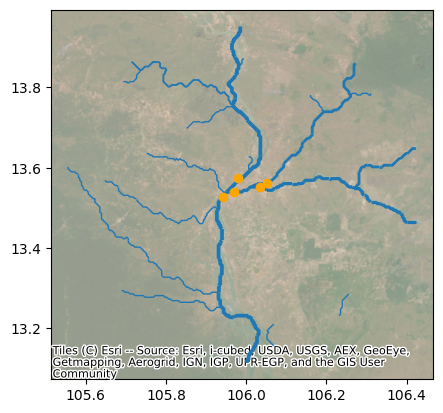

In [5]:
# download from https://www.hydrosheds.org/products/hydrorivers
hr_url = '/home/jovyan/data/HydroRIVERS_v10_as_shp'
rivers = gpd.read_file(hr_url, mask = bounds_gdf)
ax = rivers[rivers['ORD_STRA']>2].plot(linewidth=rivers[rivers['ORD_STRA']>2]['ORD_STRA']/3, zorder=10)
sampling_points.plot(ax=ax, color = "orange", zorder=20)
contextily.add_basemap(ax, 
                       crs=rivers.crs, 
                       source=contextily.providers.Esri.WorldImagery,
                      alpha = 0.5)

Identify which hydrosheds reaches are closest to each point. These may be used for 
initial analysis, but I would like to aggregate the reaches to include all reaches
between confluences. I will have to make a decision as to which confluences to include
(eg if a first-order stream flows in, will that mark a new reach, or will it only count
when higher-order streams flow in?)

In [7]:
# first reproject rivers to UTM 48
rivers_utm = rivers.to_crs(sampling_points_utm.crs)
# For each sampling point, find closest river reach, 
# ensuring that it matches with the large channel
sampling_points_merged_utm = sampling_points_utm.sjoin_nearest(rivers_utm.loc[rivers['ORD_STRA'] > 5, ['HYRIV_ID', 'geometry']], how='left')
sampling_points_merged_utm

,ele,time,name,geometry,index_right,HYRIV_ID
0,41.848339,2023-11-21 01:12:03+00:00,KSCS2-S1,POINT (606101.431 1500960.051),309,41338936
3,46.226585,2023-11-21 03:19:29+00:00,STS-1,POINT (602019.491 1495497.833),381,41340168
6,50.485073,2023-11-21 04:51:37+00:00,3SB-1,POINT (604961.861 1496949.311),332,41339305
9,44.720238,2023-11-21 08:39:23+00:00,SKG-1,POINT (613835.252 1499406.775),311,41338938
12,41.572842,2023-11-21 09:37:06+00:00,SSN-1,POINT (611893.715 1498311.861),327,41339237


In [8]:
reaches = rivers_utm.loc[sampling_points_merged_utm['index_right']]
reaches

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
309,41338936,41339304,41392598,1.94,664.1,4182.1,4.59,560079.6,0,9927.008,8,1,3,4121128230,"LINESTRING (606614.205 1500709.009, 605267.195..."
381,41340168,41341006,41392598,5.55,654.6,4191.5,22.12,639598.8,0,12891.121,8,1,2,4121128670,"LINESTRING (602572.750 1496545.269, 602123.621..."
332,41339305,41339382,41392598,6.25,660.6,561.4,11.48,79015.2,0,2940.137,7,2,3,4121128330,"LINESTRING (608879.798 1497953.045, 608430.797..."
311,41338938,41339074,41392598,10.36,669.7,543.8,35.68,28779.8,0,1076.272,6,3,3,4121128090,"LINESTRING (618317.608 1504906.781, 618321.748..."
327,41339237,41339158,41392598,4.45,668.0,554.1,7.51,50201.9,0,1860.881,7,2,3,4121128120,"LINESTRING (613841.598 1497513.052, 613388.720..."


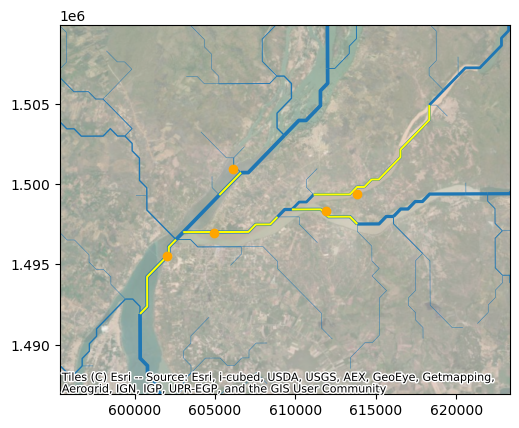

In [9]:
# visualize it
(xmin, ymin, xmax, ymax) = rivers_utm.loc[sampling_points_merged_utm['index_right']].unary_union.bounds
ax = rivers_utm.plot(linewidth=rivers['ORD_STRA']/3, zorder=1)
reaches.plot(ax=ax, color='yellow', zorder=10)
sampling_points_merged_utm.plot(ax=ax, color = "orange", zorder=20)
ax.set_xlim(xmin-5000, xmax+5000)
ax.set_ylim(ymin-5000, ymax+5000)
contextily.add_basemap(ax, 
                       crs=rivers_utm.crs.to_string(), 
                       source=contextily.providers.Esri.WorldImagery, 
                      alpha = 0.5)

# Create water polygon for each river reach 

For this, I will use the 
[JRC water classification dataset](https://global-surface-water.appspot.com/download). 

In [13]:
# Open JRC water classification dataset

water_filename = '/home/jovyan/data/occurrence_100E_20Nv1_4_2021.tif'
water_src = rio.open(water_filename)


window_bounds = rivers.unary_union.bounds
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
window = rio.windows.from_bounds(*window_bounds, transform=water_src.transform)
water = water_src.read(1, window=window)
water_ma = np.ma.masked_equal(water, water_src.nodata)
water_ma

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],
  mask=False,
  fill_value=999999,
  dtype=uint8)

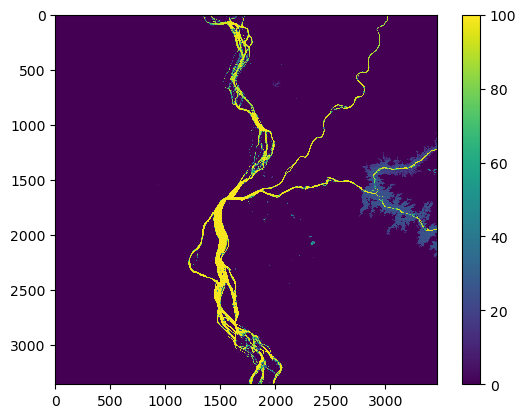

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(water_ma, interpolation='none')
fig.colorbar(im);

In [ ]:
#### Identify river reaches associated with each point ####
# Load point data for each river reach
# load hydrosheds data for 20km of large rivers surrounding the river reaches
# Identify which hydrosheds reaches are closest to each point
# optional: aggregate hydrosheds reaches so that there is one reach between each confluence

#### Create water polygon for each river reach (for 2023?) ####
# Load JRC Yearly water classification from https://global-surface-water.appspot.com/download 
# And re-project it to match HLS. 

# Create 3km (might have to increase or decrease, we will see) mask around river vector
# Identify pixels which are classified as water within the buffer
# For each pixel, identify which river reach is closest
# Exclude water pixels which are not connected to main channel
# Create polygons surrounding water pixels for each reach

<Axes: >

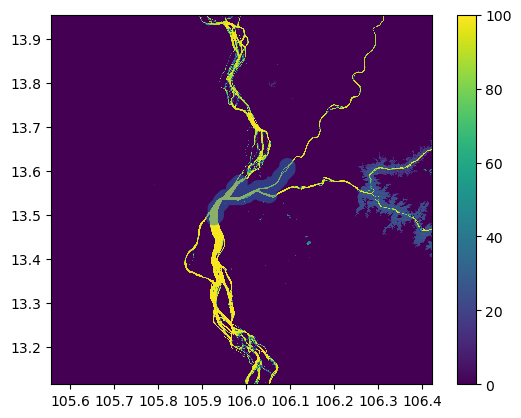

In [15]:
# create 2km mask around each river vector
buff = gpd.GeoDataFrame(geometry=gpd.GeoSeries(reaches['geometry'].buffer(2000).to_crs(water_src.crs).unary_union))
fig, ax = plt.subplots()
im = ax.imshow(water_ma, interpolation='none', zorder = 0, extent = window_extent)
fig.colorbar(im)
buff.plot(ax=ax, alpha = 0.5, zorder=100);

In [73]:
# identify pixels classified as water within the buffer
# first clip water raster to buffer
from rasterio import mask
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
# then create a mask of water pixels from those. 
river_ma, river_ma_transform  = rio.mask.mask(water_src, buff['geometry'], **rio_mask_kwargs)

So the algorithm for detecting water which this dataset comes from is not perfect, 
especially over water with high concentrations of sediments, which might reflect
more similarly to land. Upon closer inspection, it looks like I can't just use any 
portions of the water which are classified as water 100% of the time.

The tricky part is that there ARE parts of the river which are sometimes underwater 
and sometimes above water (this is mostly seasonal, depending on water level). 

You can see that there are lots of pixels which should be 100% water, but are classified 
as sometimes not underwater (more in the smaller tributaries).

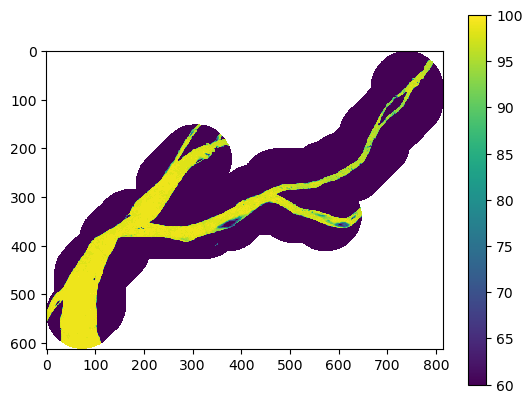

In [74]:
im = plt.imshow(river_ma, vmin = 60, vmax = 100, interpolation='none', )
plt.colorbar(im);

Here, I do a visual inspection to decide where to set my threshold. 

It looks like either 90 would sufficiently include water while excluding 
islands which are sometimes underwater

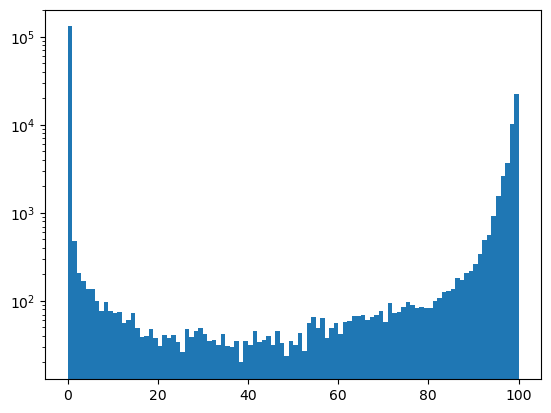

In [75]:
plt.hist(river_ma.compressed(), log=True, bins = 100);

Text(0.5, 1.0, 'threshold: >80')

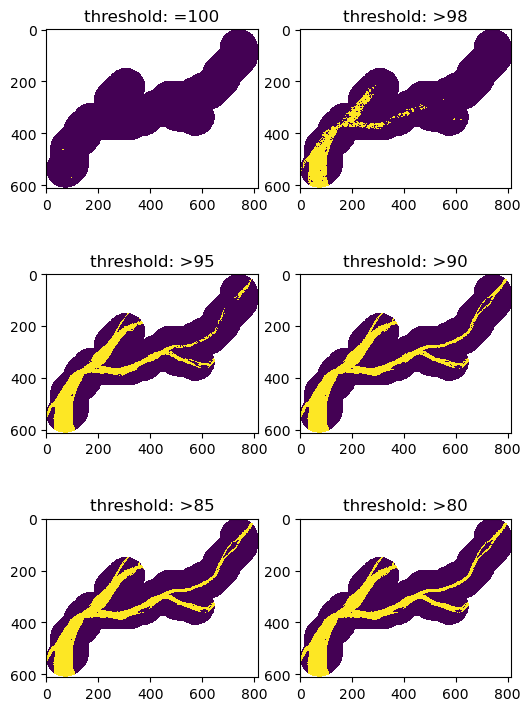

In [76]:
fig, ax = plt.subplots(3, 2, figsize=(6, 9))
ax[0,0].imshow(river_ma == 100, interpolation='none', )
ax[0,0].set_title('threshold: =100')
ax[0,1].imshow(river_ma > 98, interpolation='none', )
ax[0,1].set_title('threshold: >98')
ax[1,0].imshow(river_ma > 95, interpolation='none', )
ax[1,0].set_title('threshold: >95')
ax[1,1].imshow(river_ma > 90, interpolation='none', )
ax[1,1].set_title('threshold: >90')
ax[2,0].imshow(river_ma > 85, interpolation='none', )
ax[2,0].set_title('threshold: >85')
ax[2,1].imshow(river_ma > 80, interpolation='none', )
ax[2,1].set_title('threshold: >80')

Another option would be to create a different mask for each year using 
HLS data. To do this, I would choose a cloud-free image from near the minimum
water level (luckily, this is easy to do because low water level occurs
when there are very few clouds). 

For now, I'll just use a threshold of 90. 

In [81]:
river_ma[river_ma < 90] = np.ma.masked

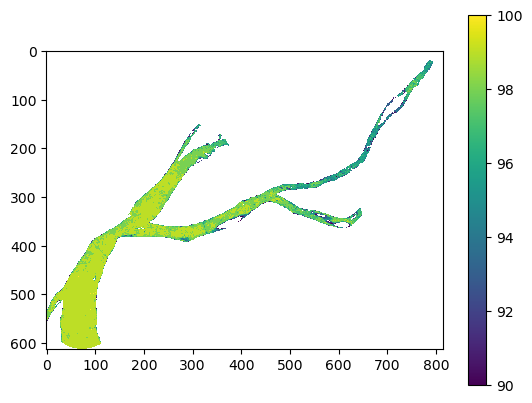

In [82]:
im = plt.imshow(river_ma, interpolation = 'none')
plt.colorbar(im);